# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [3]:
import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 

from hwutils import plot_pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler



In [4]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('ENCODE_GRCh38_bigWig_metadata.tsv')

C:\Users\marca\AppData\Local\Temp\ipykernel_34140\1843482741.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


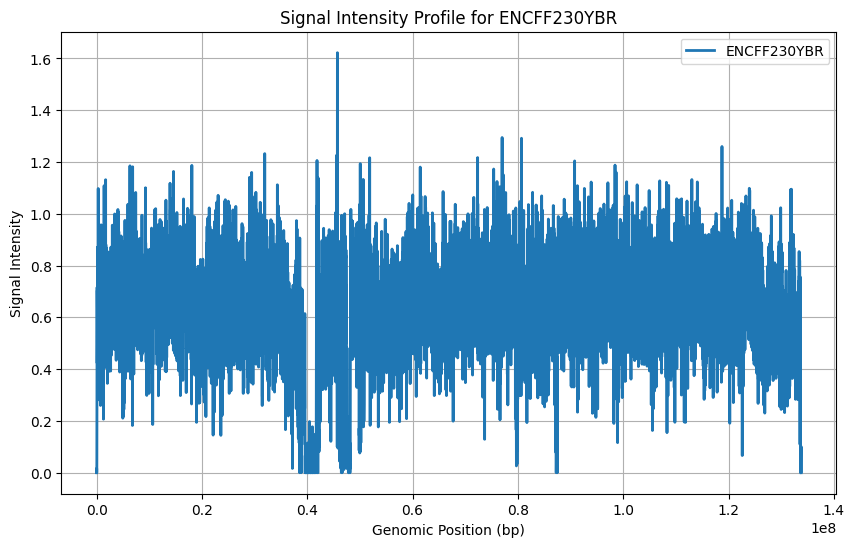

In molecular biology experiments like ChIP-seq, PCR artifacts can occur. These artifacts may lead to a decrease in signal intensity at specific genomic locations. This dip could represent a region of active biological regulation. It might be a binding site for a transcription factor.


In [5]:
file_to_visualize = 'ENCFF230YBR'

genomic_positions = df['start']
signal_intensity = df[file_to_visualize]

plt.figure(figsize=(10, 6))  
plt.plot(genomic_positions, signal_intensity, label=file_to_visualize, linewidth=2)
plt.xlabel('Genomic Position (bp)')
plt.ylabel('Signal Intensity')
plt.title(f'Signal Intensity Profile for {file_to_visualize}')
plt.legend()
plt.grid(True)

plt.show()

print('In molecular biology experiments like ChIP-seq, PCR artifacts can occur. These artifacts may lead to a decrease in signal intensity at specific genomic locations. This dip could represent a region of active biological regulation. It might be a binding site for a transcription factor.') 

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


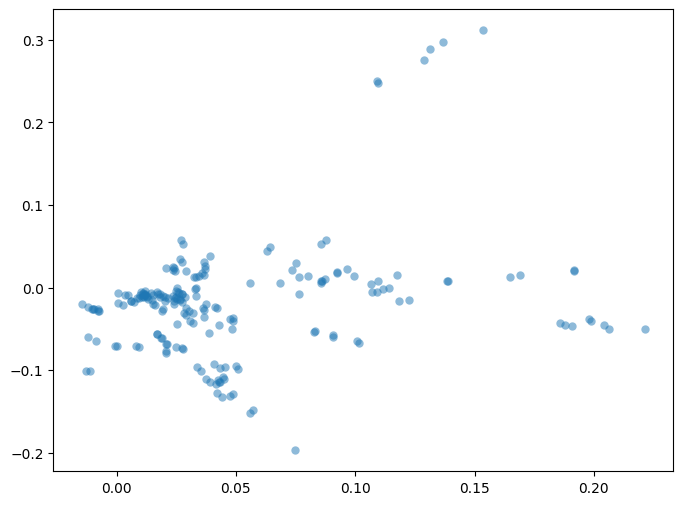

In [6]:
df = pd.read_table('ENCODE_GRCh38_binned_subset.tsv')

data_for_pca = df.iloc[:, 3:]  

pca = PCA(n_components=2)

principal_components = pca.fit_transform(data_for_pca)

plot_pca(pca=pca, figsize=(8, 6))



- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

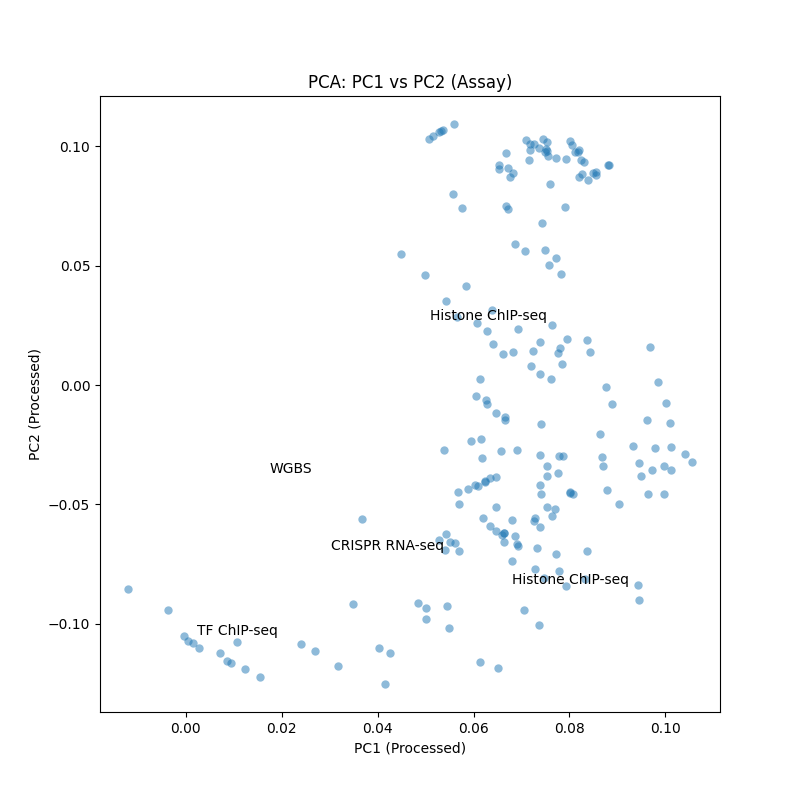

In [11]:
%matplotlib inline

data_for_pca = df.iloc[:, 3:]  

pca = PCA(n_components=2)

principal_components = pca.fit_transform(data_for_pca)

data_for_pca = df.iloc[:, 3:].copy()

scaler = StandardScaler()
data_for_pca = scaler.fit_transform(data_for_pca)

pca_processed = PCA(n_components=2)
principal_components_processed = pca_processed.fit_transform(data_for_pca)

assay_labels = bigwig_metadata['Assay']
#plt.figure(figsize=(8, 8))
plot_pca(pca_processed)
plt.xlabel('PC1 (Processed)')
plt.ylabel('PC2 (Processed)')
plt.title('PCA: PC1 vs PC2 (Assay)')

for i, assay_label in enumerate(assay_labels):
    if i < len(data_for_pca):
        plt.text(principal_components_processed[i, 0], principal_components_processed[i, 1], assay_label, fontsize=10)

plt.show()

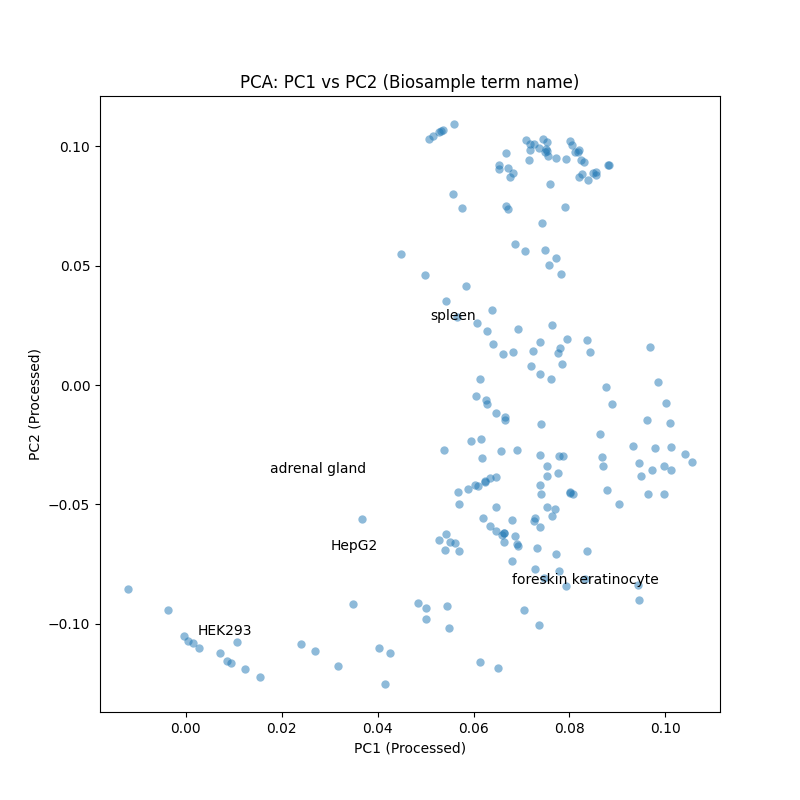

In [12]:
biosample_labels = bigwig_metadata['Biosample term name']
plt.figure(figsize=(8, 8))
plot_pca(pca_processed)
plt.xlabel('PC1 (Processed)')
plt.ylabel('PC2 (Processed)')
plt.title('PCA: PC1 vs PC2 (Biosample term name)')

for i, biosample_label in enumerate(biosample_labels):
    if i < len(data_for_pca):
        plt.text(principal_components_processed[i, 0], principal_components_processed[i, 1], biosample_label, fontsize=10)

plt.show()

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


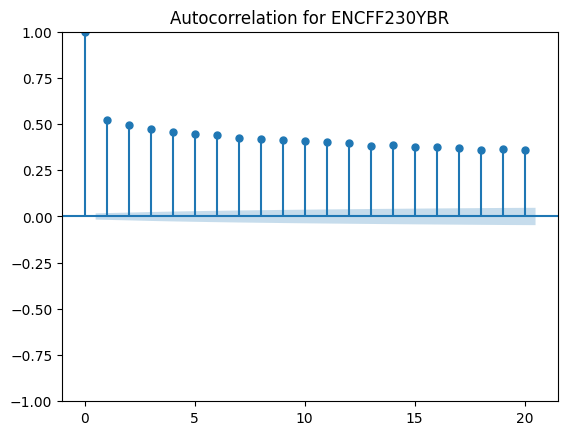

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

transcription_factor_columns = ['ENCFF230YBR']  

fig, axes = plt.subplots(len(transcription_factor_columns), 1, figsize=(8, 4 * len(transcription_factor_columns)))

for i, column in enumerate(transcription_factor_columns):
    autocorrelation = sm.tsa.acf(df[column], fft=False)
    lags = range(len(autocorrelation))
    
    axes[i].stem(lags, autocorrelation, use_line_collection=True)
    axes[i].set_title(f'Autocorrelation for {column}')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()
print('This transcription factor shows broad patterns.')

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


In [ ]:

print('Biosample HEK293 is close to TF Chip seq')

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 

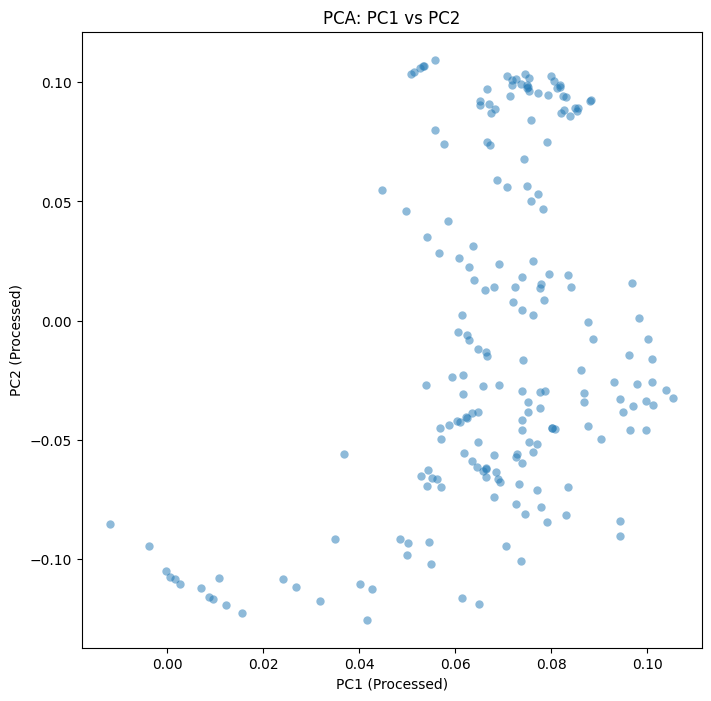

In [ ]:
data_for_pca = df.iloc[:, 3:].copy()

scaler = StandardScaler()
data_for_pca = scaler.fit_transform(data_for_pca)

pca_original = PCA(n_components=2)
principal_components_original = pca_original.fit_transform(data_for_pca)

plot_pca(pca_original, figsize=(8, 8))
plt.xlabel('PC1 (Processed)')
plt.ylabel('PC2 (Processed)')
plt.title('PCA: PC1 vs PC2')

plt.show()

print('Preprocessing significantly changes the data')

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


Number of PCs needed to explain 90% of variance: 1


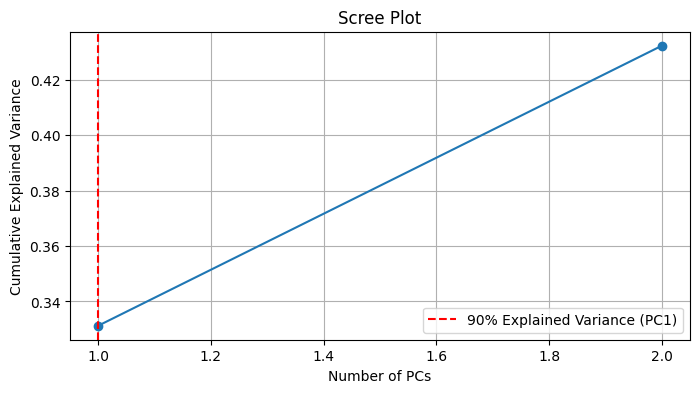

In [ ]:
pca_processed = PCA(n_components=2)
principal_components_processed = pca_processed.fit_transform(data_for_pca)
explained_variance_ratio_cumulative = np.cumsum(pca_processed.explained_variance_ratio_)

n_components_90_percent = np.argmax(explained_variance_ratio_cumulative >= 0.9) + 1

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca_processed.explained_variance_ratio_) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=n_components_90_percent, color='r', linestyle='--', label=f'90% Explained Variance (PC{n_components_90_percent})')
plt.legend()
plt.grid()

print(f"Number of PCs needed to explain 90% of variance: {n_components_90_percent}")


- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


C:\Users\marca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


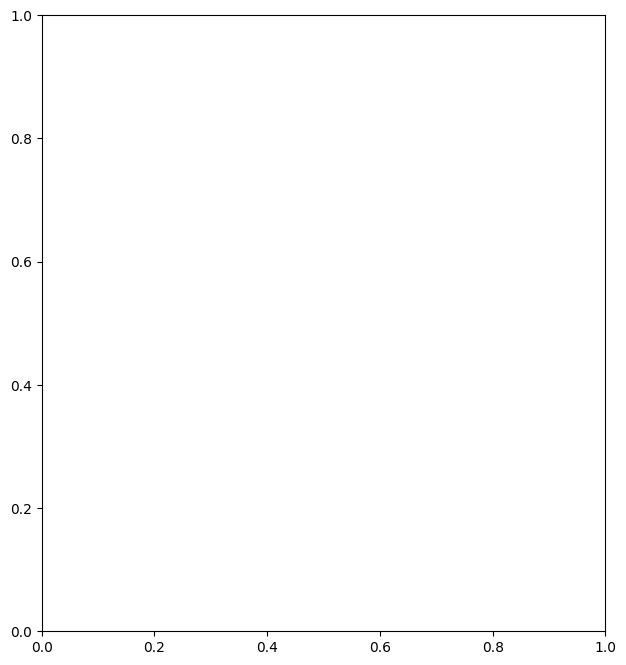

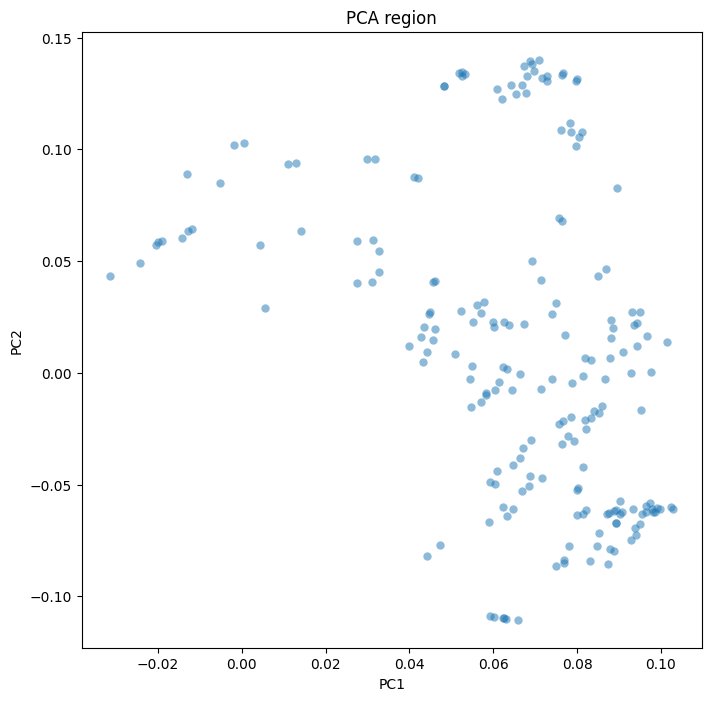

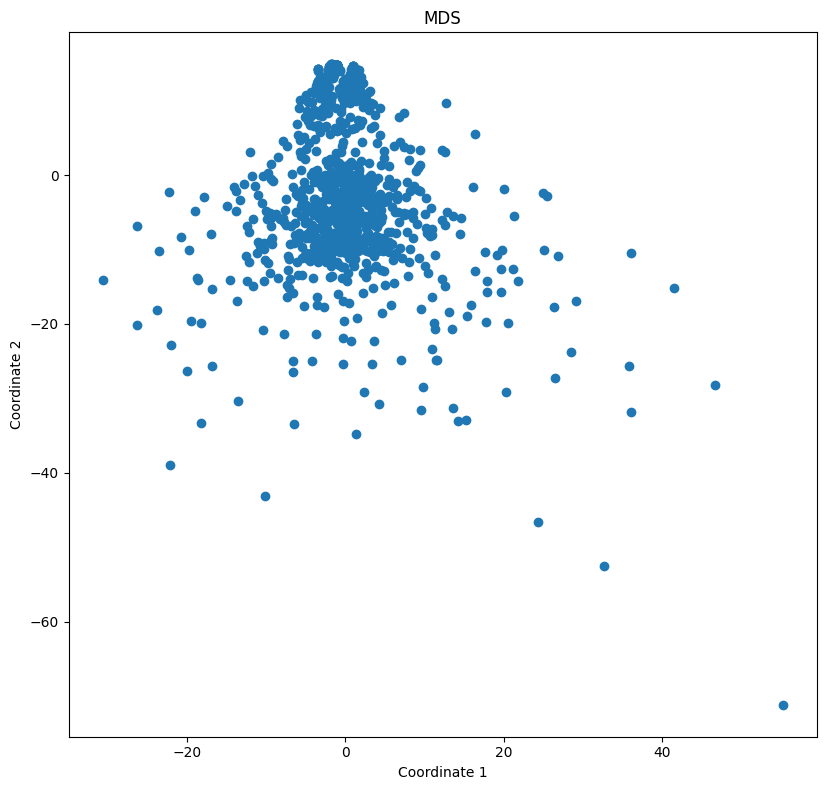

MDS is non linear, and does not assume linearity for variables. PCA is linear, it assumes linear relationship between variables.


In [ ]:
#MDS
chromosome_of_interest = 'chr10'
start_position = 40000000
end_position = 50000000

restricted_data = df[(df['chrom'] == chromosome_of_interest) & (df['start'] >= start_position) & (df['end'] <= end_position)]

numeric_data = restricted_data.select_dtypes(include=[np.number])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

mds = MDS(n_components=2, random_state=0)
scaled_df = mds.fit_transform(scaled_data)

pca_region = PCA(n_components=2)
principal_components_region = pca_region.fit_transform(numeric_data)

#Comparison PCA Plot
plt.figure(figsize=(16, 8))
plt.subplot(121)
plot_pca(pca_processed, figsize=(8, 8))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA region')

#Comparison: MDS Plot
plt.figure(figsize=(16, 8))
plt.subplot(122)
plt.scatter(scaled_df[:, 0], scaled_df[:, 1])
plt.title('MDS')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.tight_layout()
plt.show()

print('MDS is non linear, and does not assume linearity for variables. PCA is linear, it assumes linear relationship between variables.')


- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


print('NMF can be used for clustering the data, which is relevant in genomics to identify groups of genes or genomic regions with similar patterns of expression. NMF is particularly suited for datasets where the values are non-negative.')
